In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

import numpy as np
import scipy as sp
from scipy import spatial as spatial

In [2]:
# Purity scores function
from sklearn import metrics
from scipy.optimize import linear_sum_assignment
def purity_score(y_true, y_pred):
    
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix= metrics.cluster.contingency_matrix(y_true, y_pred) #print(contingency_matrix)
    
    # Find optimal one-to-one mapping between cluster labels and true labels
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    
    # Return cluster accuracy
    return contingency_matrix[row_ind,col_ind].sum() / np.sum(contingency_matrix)


def dbscan_predict(dbscan_model, X_new, metric=spatial.distance.euclidean):
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1
 
    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_):
            if metric(x_new, x_core) < dbscan_model.eps: # Assign label of x_core to x_new 
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]] 
                break
    return y_new

In [3]:
data = pd.read_csv("Iris.csv")

In [4]:
labels = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
map_labels = lambda x: labels[x]
true_predictions = data.Species.apply(map_labels)

In [5]:
data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


# Answer1

Eigen values of projected data are: 


Text(0, 0.5, 'Eigen Values')

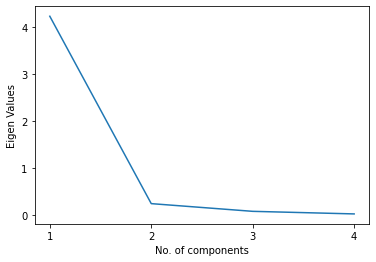

In [6]:
pca = PCA(n_components=4)
reduced_data = pd.DataFrame(pca.fit_transform(data.iloc[:, :4]))
evecs = pca.components_ 
evals = pca.explained_variance_
print("Eigen values of projected data are: ")
plt.plot([1, 2, 3, 4], evals)
plt.xticks([1, 2, 3, 4])
plt.xlabel("No. of components")
plt.ylabel("Eigen Values")

In [7]:
reduced_data = reduced_data.iloc[:, :2]
reduced_data

,0,1
0,-2.684207,0.326607
1,-2.715391,-0.169557
2,-2.889820,-0.137346
3,-2.746437,-0.311124
4,-2.728593,0.333925
...,...,...
145,1.944017,0.187415
146,1.525664,-0.375021
147,1.764046,0.078519
148,1.901629,0.115877


# Answer2

In [8]:
K = 3
kmeans = KMeans(n_clusters=K)
kmeans.fit(reduced_data)
kmeans_prediction = kmeans.predict(reduced_data)

kmean_centers = kmeans.cluster_centers_
print("The center of the cluster are: ")
print(kmean_centers)

The center of the cluster are: 
[[ 2.34645113  0.27235455]
 [-2.64084076  0.19051995]
 [ 0.66443351 -0.33029221]]


## A

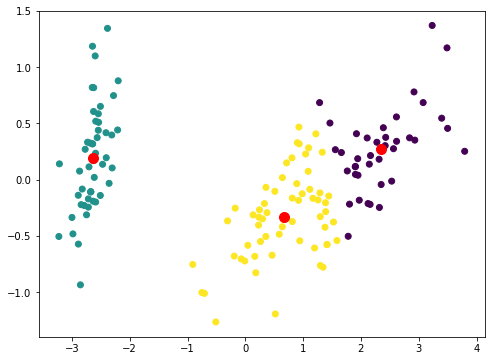

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], c=kmeans_prediction.astype(float))
plt.plot(kmean_centers[:, 0], kmean_centers[:, 1], "r.", markersize=20)

## B

In [10]:
print("The distortion measure is: ")
print(kmeans.inertia_)

The distortion measure is: 
63.873838060362274


## C

In [11]:
print(f"The purity score is: {purity_score(true_predictions, kmeans_prediction)}")

The purity score is: 0.8866666666666667


# Answer3

Text(0, 0.5, 'Distortion Measure')

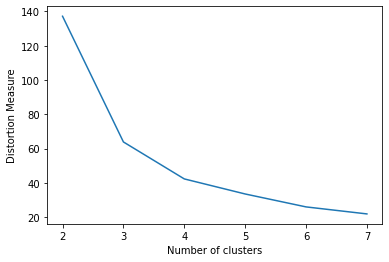

In [12]:
Ks = [2, 3, 4, 5, 6, 7]

distortion_measures = []
p_scores = []

for k in Ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_data)
    kmeans_prediction = kmeans.predict(reduced_data)
    distortion_measures.append(kmeans.inertia_)
    p_score = purity_score(true_predictions, kmeans_prediction)
    p_scores.append(p_score)

plt.plot(Ks, distortion_measures)
plt.xlabel("Number of clusters")
plt.ylabel("Distortion Measure")

In [13]:
print(f"The purity scores are: {(p_scores)}")

The purity scores are: [0.6666666666666666, 0.8866666666666667, 0.6866666666666666, 0.6733333333333333, 0.52, 0.5133333333333333]


## Answer4

In [14]:
K=3
gmm = GaussianMixture(n_components = K) 
gmm.fit(reduced_data)
GMM_prediction = gmm.predict(reduced_data)


## A

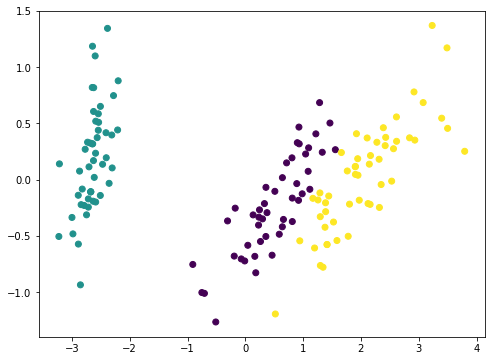

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], c=GMM_prediction.astype(float))

## B

In [16]:
print(f"Total data log likelihood is: {sum(gmm.score_samples(reduced_data))}")

Total data log likelihood is: -280.8695650450795


## C

In [17]:
print(f"The purity score is: {purity_score(true_predictions, GMM_prediction)}")

The purity score is: 0.98


# Answer5

Text(0, 0.5, 'Total data log likelihood')

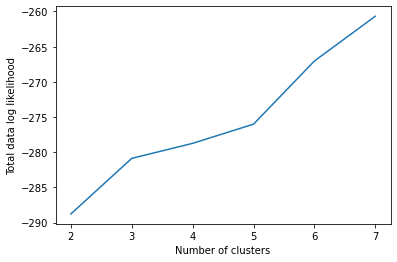

In [18]:
gmm_total_data_logLikelihood = []
gmm_p_scores = []

for k in Ks:
    gmm = GaussianMixture(n_components = k) 
    gmm.fit(reduced_data)
    GMM_prediction = gmm.predict(reduced_data)
    gmm_total_data_logLikelihood.append(sum(gmm.score_samples(reduced_data)))
    gmm_p_score = purity_score(true_predictions, GMM_prediction)
    gmm_p_scores.append(gmm_p_score)
    
plt.plot(Ks, gmm_total_data_logLikelihood)
plt.xlabel("Number of clusters")
plt.ylabel("Total data log likelihood")

In [19]:
print(f"The purity scores are: {gmm_p_scores}")

The purity scores are: [0.6666666666666666, 0.98, 0.8266666666666667, 0.7666666666666667, 0.6933333333333334, 0.6333333333333333]


# Answer6

## Model1

## Model2

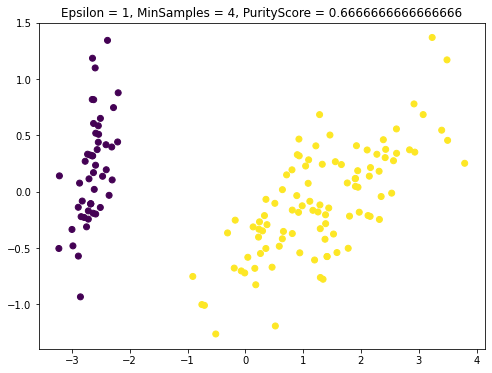

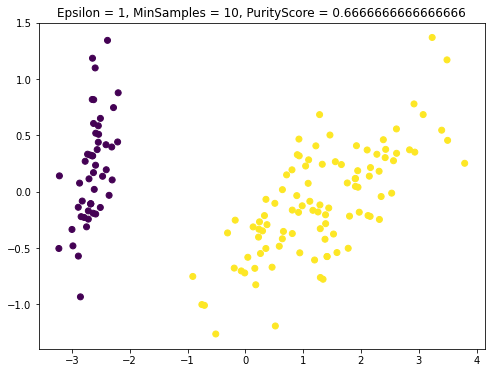

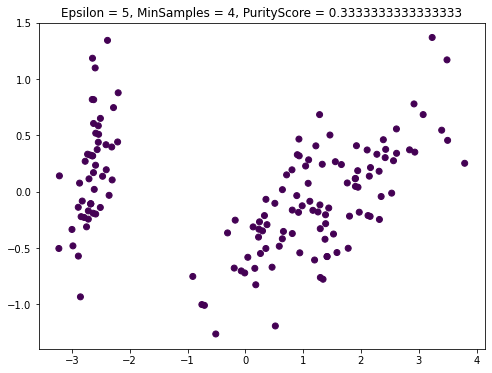

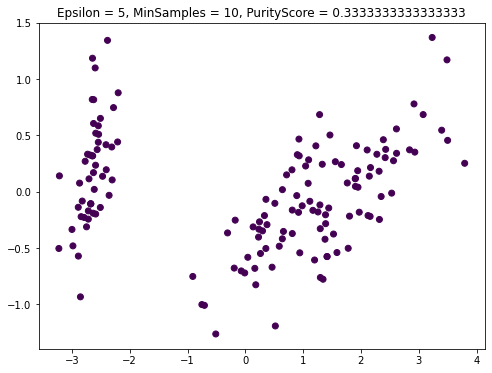

In [20]:
configs = [(1, 4), (1, 10), (5, 4), (5, 10)]

for config in configs:
    eps, min_samples = config
    dbscan_model =DBSCAN(eps=eps, min_samples=min_samples).fit(reduced_data)
    DBSCAN_predictions = dbscan_model.labels_
    plt.figure(figsize=(8, 6))
    p_score = purity_score(true_predictions, DBSCAN_predictions)
    plt.title(f"Epsilon = {eps}, MinSamples = {min_samples}, PurityScore = {p_score}")
    plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], c=DBSCAN_predictions.astype(float))